In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (roc_auc_score, 
                             precision_score, 
                             recall_score,
                             f1_score, 
                             accuracy_score, 
                             homogeneity_score, 
                             completeness_score, 
                             v_measure_score,
                             silhouette_score)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, affinity_propagation
import scipy.cluster.hierarchy as shc

from sklearn.model_selection import train_test_split
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.tree import (DecisionTreeClassifier, plot_tree)
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette=["#000003", "#932567", "#DC5039", "#FBA40A"], 
                    legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

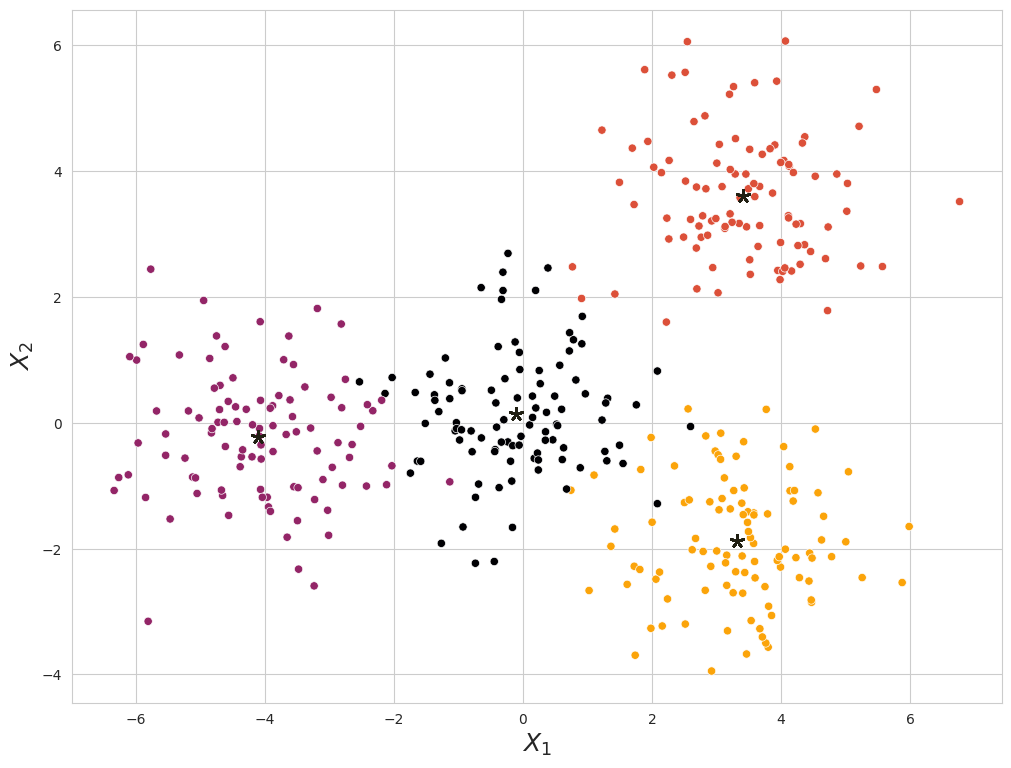

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайшего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=30, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
            
        cluster_labels = np.argmin(dists, axis=1)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """

        dist = np.sqrt(np.sum((X - centroid) ** 2, axis=1)).reshape(X.shape[0], 1)
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игрушечных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

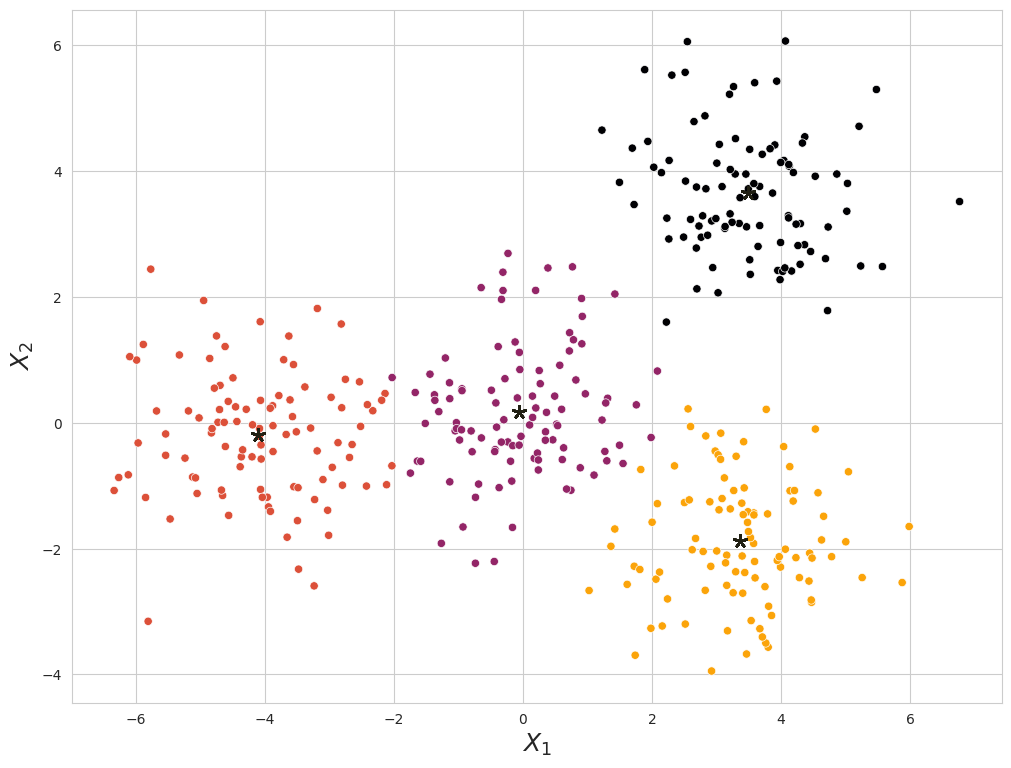

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
# random
k_means_random = MyKMeans(4, init="random", visualize=True)
k_means_random.fit(X)

In [8]:
predicted_labels_random = k_means_random.predict(X)

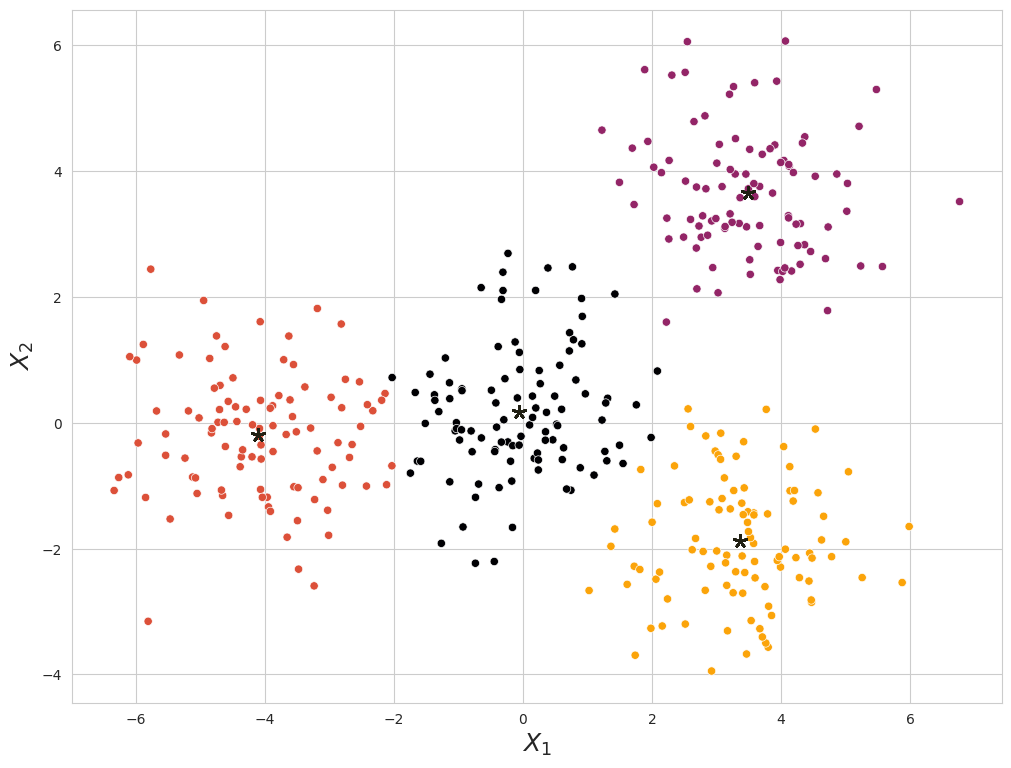

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
# sample
k_means_sample = MyKMeans(4, init="sample", visualize=True)
k_means_sample.fit(X)

In [10]:
predicted_labels_sample = k_means_sample.predict(X)

#### Сравним два варианта

In [11]:
print("Сравнение метрик для различных способов инициализации центроидов")
print()
print("Precision score for random =", round(precision_score(true_labels, predicted_labels_random, average="macro"), 2))
print("Precision score for sample =", round(precision_score(true_labels, predicted_labels_sample, average="macro"), 2))
print()
print("Recall score for random =", round(recall_score(true_labels, predicted_labels_random, average="macro"), 2))
print("Recall score for sample =", round(recall_score(true_labels, predicted_labels_sample, average="macro"), 2))
print()
print("F1 score for random =", round(f1_score(true_labels, predicted_labels_random, average="macro"), 2))
print("F1 score for sample =", round(f1_score(true_labels, predicted_labels_sample, average="macro"), 2))
print()
print("Accuracy score for random =", round(accuracy_score(true_labels, predicted_labels_random), 2))
print("Accuracy score for sample =", round(accuracy_score(true_labels, predicted_labels_sample), 2))
print()
print("Silhouette_score score for random =", round(silhouette_score(X, predicted_labels_random), 2))
print("Silhouette_score for sample =", round(silhouette_score(X, predicted_labels_sample), 2))

Сравнение метрик для различных способов инициализации центроидов

Precision score for random = 0.25
Precision score for sample = 0.48

Recall score for random = 0.24
Recall score for sample = 0.48

F1 score for random = 0.25
F1 score for sample = 0.48

Accuracy score for random = 0.24
Accuracy score for sample = 0.48

Silhouette_score score for random = 0.56
Silhouette_score for sample = 0.56


Все показатели ужасные, но, если выбирать из двух зол, то метод инициации центроидов от имеющихся точек (sample) лучше.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [12]:
data = load_digits()
X, y = data.data, data.target

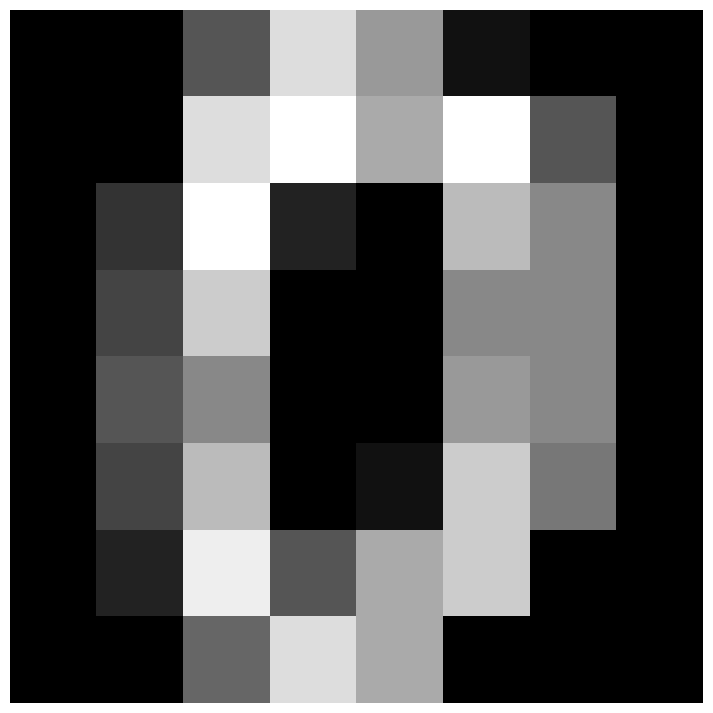

In [13]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

Посмотрим на все классы.
Возьмём по одной картинке каждого класса и изобразим их.

In [14]:
data = pd.DataFrame(X)
data['y'] = y
examples = data.groupby('y').first()

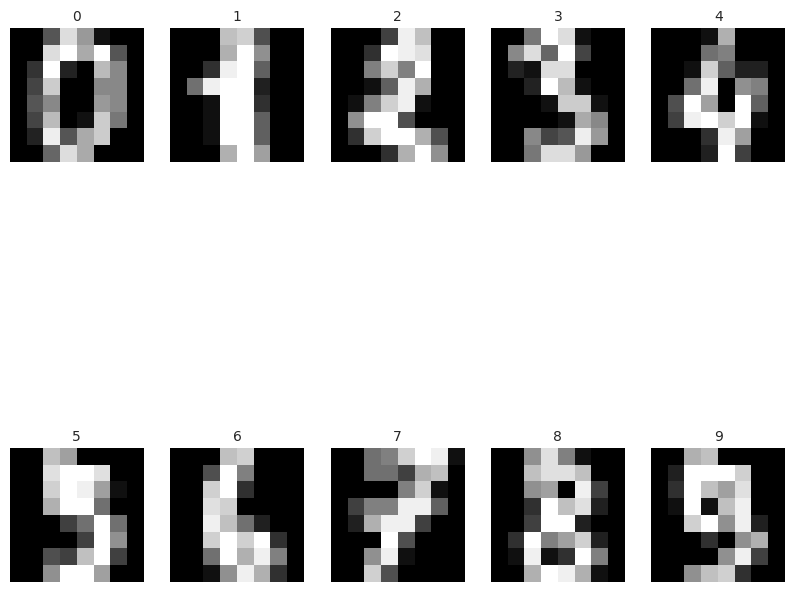

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
for row, ax in zip(examples.index, axes.flatten()):
    image1 = np.array(examples.loc[row]).reshape(8, 8, 1)
    ax.imshow(image1, cmap="gray")
    ax.axis("off");
    ax.set_title(row, fontsize=10)

Посмотрим на баланс классов.

In [16]:
# баланс классов соблюден: классы одного количественного порядка; кластеров, что логично, 10 :)
data['y'].value_counts() 

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: y, dtype: int64

In [17]:
# задаём пространство для манёвра
distances = ["manhattan", "euclidean", "minkowski", "cosine"]
linkages = ["average", "single", "complete"]
metrics = [homogeneity_score, completeness_score, v_measure_score, silhouette_score]

In [18]:
def algorithm_selection(X, y, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    compare_dataframe_list = []
    
    for linkage in algorithms:
        for distance in distances:
            clusterer = AgglomerativeClustering(n_clusters=10, 
                                                affinity=distance, 
                                                linkage=linkage)
            y_pred = clusterer.fit_predict(X)
            cur_row = [linkage, distance]
            
            for metric in metrics:
                if metric == silhouette_score:
                    cur_row.append(metric(X, y_pred))
                else:
                    cur_row.append(metric(y, y_pred))
                    
            compare_dataframe_list.append(cur_row)          
    
    compare_dataframe = pd.DataFrame(compare_dataframe_list, 
                                     columns=["linkage",
                                              "distance", 
                                              "homogeneity score", 
                                              "completeness score", 
                                              "v measure score", 
                                              "silhouette score"])
    compare_dataframe = compare_dataframe.sort_values(by=["homogeneity score",
                                                          "completeness score",
                                                          "v measure score",
                                                          "silhouette score"],
                                                      ascending=False)
    
    return compare_dataframe

In [19]:
algorithm_selection(X, y, distances, linkages, metrics)

linkage   distance  homogeneity score  completeness score  \
1    average  euclidean           0.655393            0.782342   
2    average  minkowski           0.655393            0.782342   
3    average     cosine           0.648268            0.808762   
8   complete  manhattan           0.646372            0.686109   
9   complete  euclidean           0.590549            0.637772   
10  complete  minkowski           0.590549            0.637772   
0    average  manhattan           0.566751            0.778942   
11  complete     cosine           0.528727            0.577415   
4     single  manhattan           0.005102            0.276237   
5     single  euclidean           0.005056            0.273755   
6     single  minkowski           0.005056            0.273755   
7     single     cosine           0.005050            0.273389   

    v measure score  silhouette score  
1          0.713263          0.146625  
2          0.713263          0.146625  
3          0.719676          0.129526  
8          0.665648          0.140183  
9          0.613253          0.119271  
10         0.613253          0.119271  
0          0.656117          0.089217  
11         0.551999          0.088021  
4          0.010019         -0.166627  
5          0.009929         -0.133621  
6          0.009929         -0.133621  
7          0.009916         -0.158250

Видим, что из linkage лучше выбрать average или complete; из distances - euclidian или minkowski.

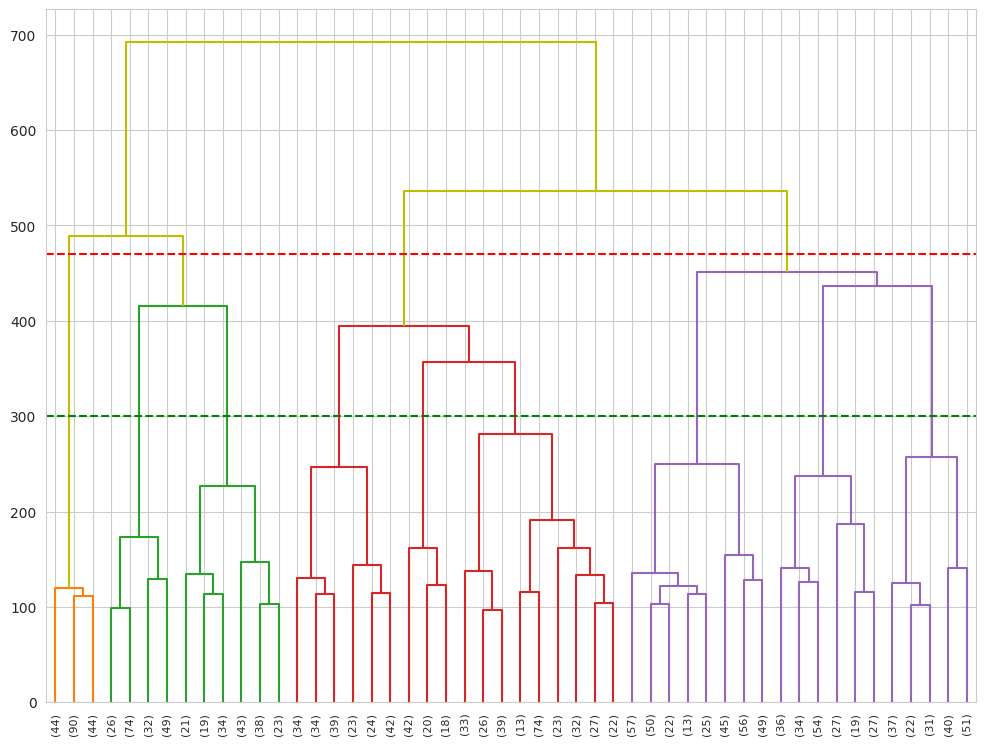

In [20]:
# можно визуализировать дендрограмму для последних 50-ти слияний; 
# видим, что резких скачков расстояний нет, т.е. мы не пытаемся объединить кластеры, сильно далёкие друг от друга
dendro = shc.linkage(X, method='ward')
shc.dendrogram(dendro, truncate_mode='lastp', p=50, above_threshold_color='y')

# при пороговом значении 470 получим 4 явно выделяющихся кластера
plt.axhline(y=470, color='r', linestyle='--')

# а при пороговом значении 300 - 9 кластеров
plt.axhline(y=300, color='g', linestyle='--')
plt.show();

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевидные выбросы?)

Кратко - о чём речь.    
Проточный цитофлуориметр – это прибор, позволяющий измерять оптические свойства индивидуальных клеток в суспензии. 

* сигнал прямого светорассеяния (FSC, "forward scatter") выше от более крупных объектов;
* сигнал бокового светорассеяния (SSC, "side scatter") выше от объектов бόльшей гранулярности (наличие гранул, везикул, других внутриклеточных включений, соотношение ядро-цитоплазма и т.п).

Комбинация FSC и SSC позволяет судить о морфологии клетки в целом и даже без анализа флуоресценции является довольно информативной при анализе популяций клеток в образце.

[Проточная цитофлуориметрия: учебно-методическое пособие](http://www.unn.ru/books/met_files/flow_cytometry.pdf?ysclid=leklos5nyk738313523)

In [21]:
fc_data = pd.read_csv(join("./data/flow_c_data.csv"), index_col=0)
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [22]:
print(f'В нашем распоряжении {fc_data.shape[0]} клеток и {fc_data.shape[1]} признаков')

В нашем распоряжении 10000 клеток и 9 признаков


##### YOUR TURN TO CODE:

In [23]:
# в данных нет NA...
fc_data.isna().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [24]:
# и нет нулевых показателей
fc_data.isnull().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [25]:
# все данные числового типа (float64)
fc_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [26]:
# получаем основные описательные статистики; отмечаем необходимость проведения стандартизации: среднее и стандартное отклонения
# различаются, без стандартизации это внесет неприемлемый дисбаланс в работу модели
fc_data.describe().round(2)

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
count  10000.00  10000.00  10000.00  10000.00  10000.00  10000.00  10000.00   
mean       0.96      0.17      1.79      3.28      5.17      1.10      0.41   
std        0.50      0.19      2.03      2.11      0.52      1.38      1.18   
min        0.14      0.02     -7.63     -2.52     -8.33     -8.83    -12.36   
25%        0.80      0.11      0.28      1.40      4.92      0.39     -0.20   
50%        0.91      0.13      1.19      4.37      5.23      0.67      0.05   
75%        1.05      0.16      3.70      4.84      5.48      1.07      0.38   
max       42.95     15.46     12.95     13.84     13.71      6.29      6.46   

           CD19     CD11c  
count  10000.00  10000.00  
mean       1.22      0.57  
std        2.29      1.50  
min       -9.64    -11.09  
25%       -0.15     -0.50  
50%        0.24      0.27  
75%        0.91      1.22  
max        7.21      6.84

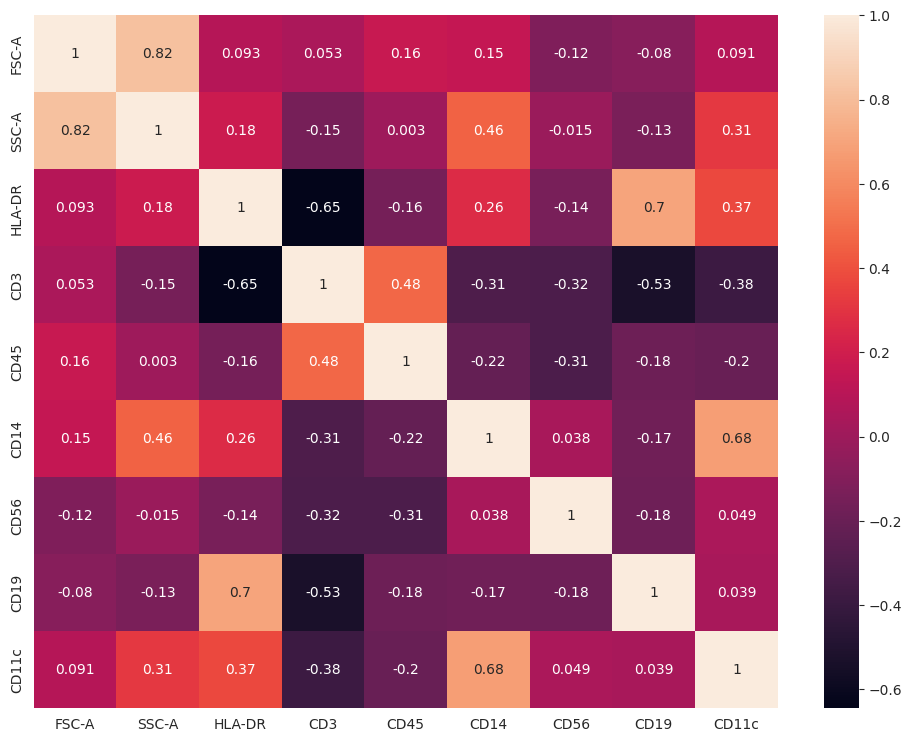

In [27]:
sns.heatmap(fc_data.corr(), annot=True);

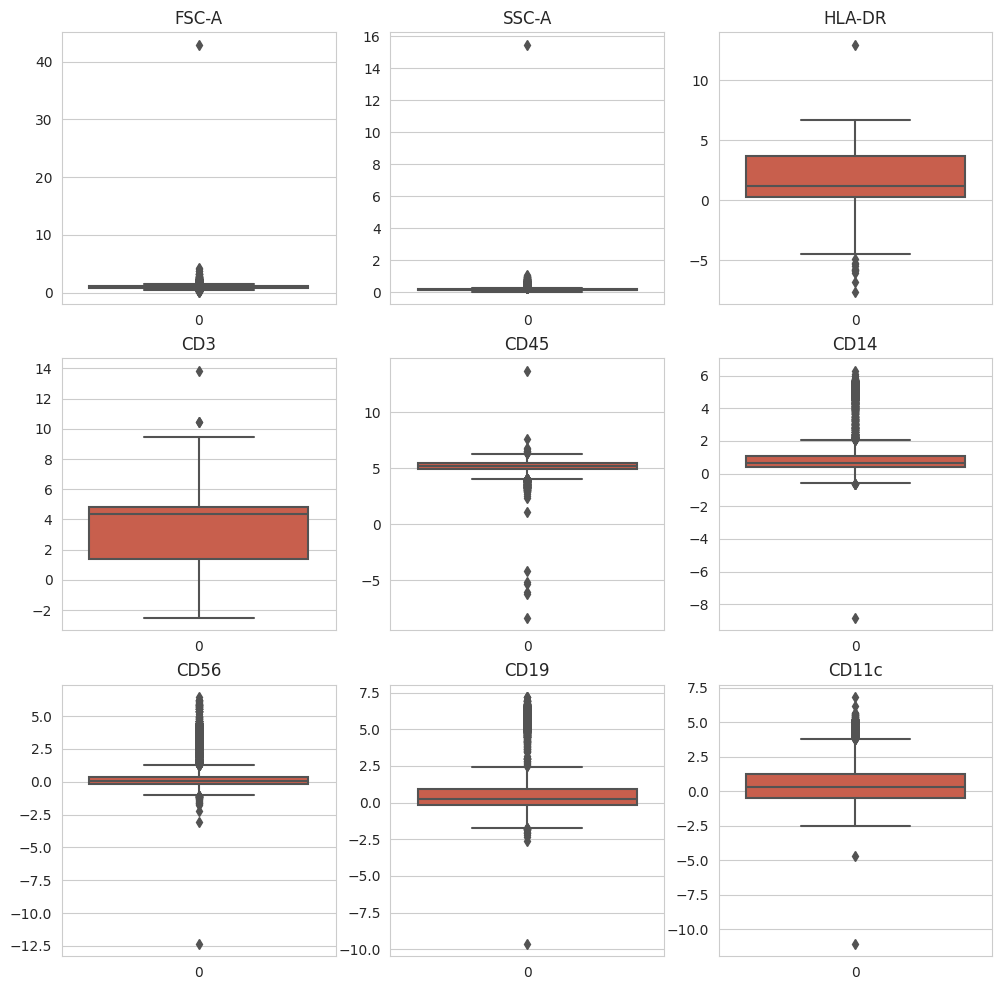

In [28]:
# да, выбросы есть
feature_names = fc_data.columns

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, axis in enumerate(axes.ravel()):
    sns.boxplot(fc_data.iloc[:, col], 
                ax=axis, 
                color='#DC5039')
    axis.set_title(feature_names[col], );

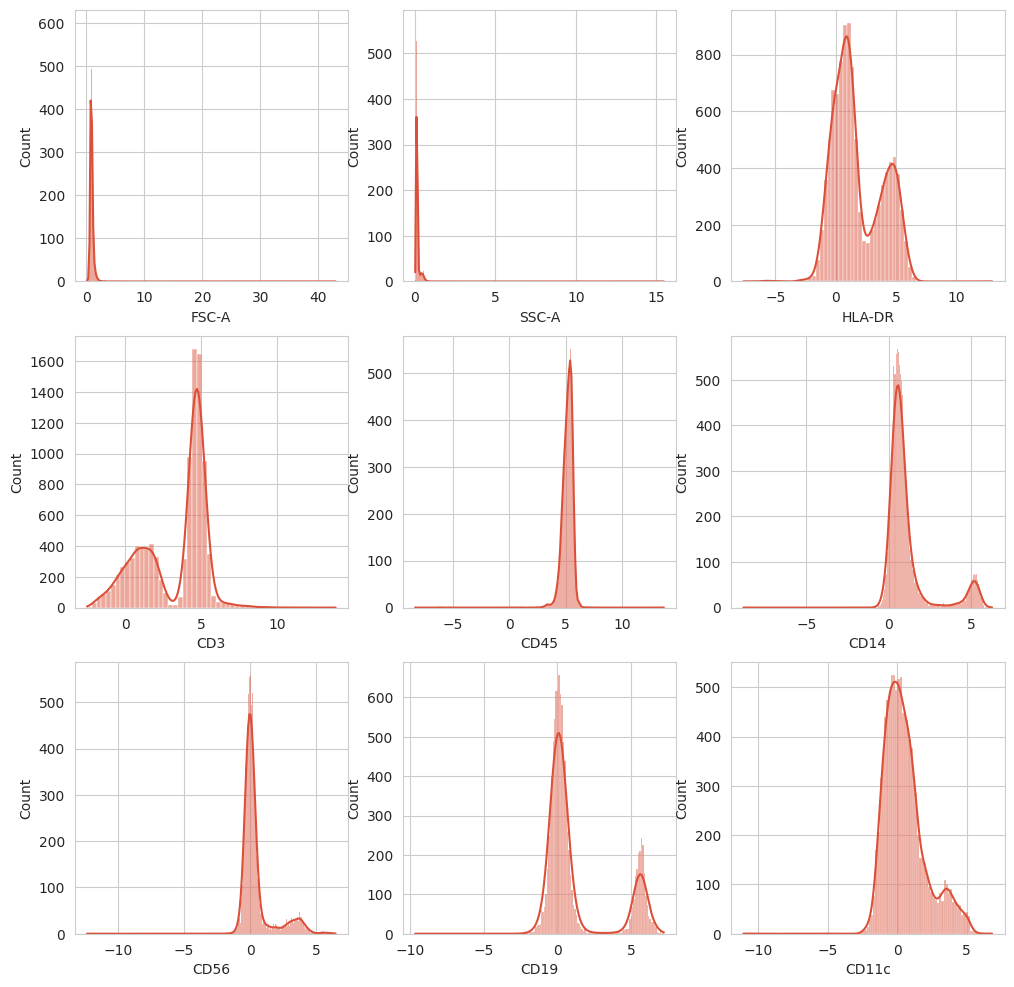

In [29]:
# да, распределение признаков далеко от нормального
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for col, axis in enumerate(axes.ravel()):
    sns.histplot(x=fc_data.iloc[:, col], 
                 ax=axis, 
                 color='#DC5039', 
                 kde=True);

Определенно мы наблюдаем выбросы, и серьёзные. Особенно это касается FSC-A и SSC-A - в их случае просто космос.

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [30]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, 
                    palette=["#410967", "#932567", "#DC5039", "#FBA40A"], 
                    color="#DC5039")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

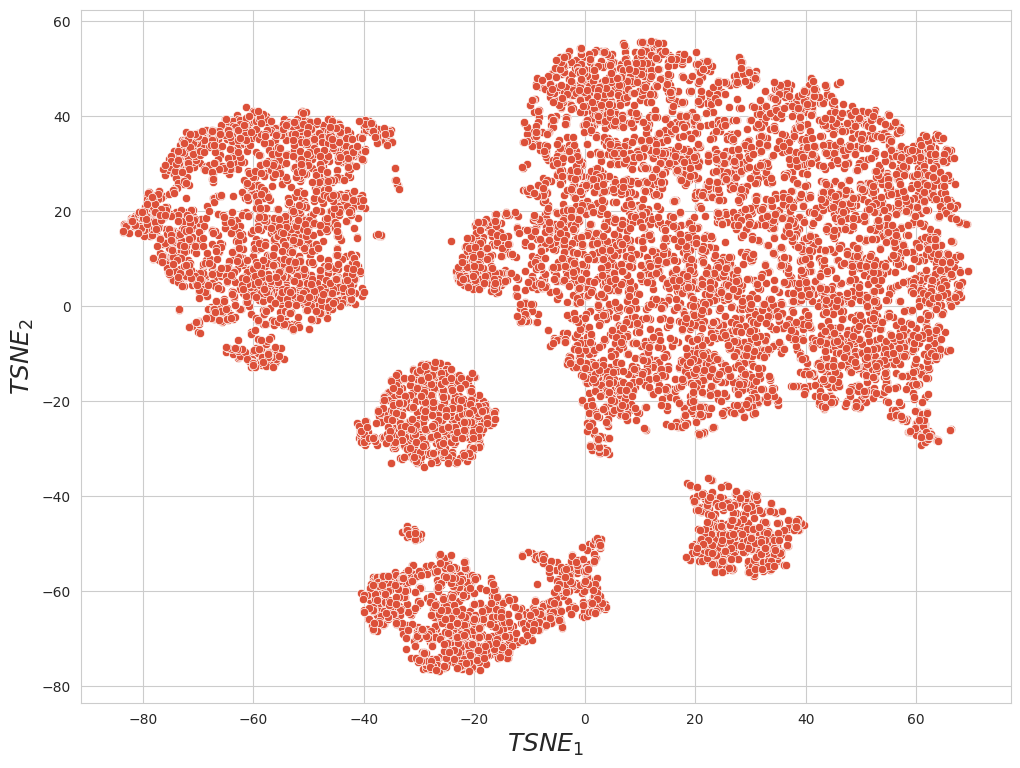

In [31]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [32]:
# K-Means 
# покрасить кластеры получилось терпимоб учётом тех самых выбросов
kmeans_clusterer = KMeans(n_clusters=4, max_iter=300, algorithm="lloyd")
kmeans_res = kmeans_clusterer.fit(fc_data)
np.unique(kmeans_res.labels_)

array([0, 1, 2, 3], dtype=int32)

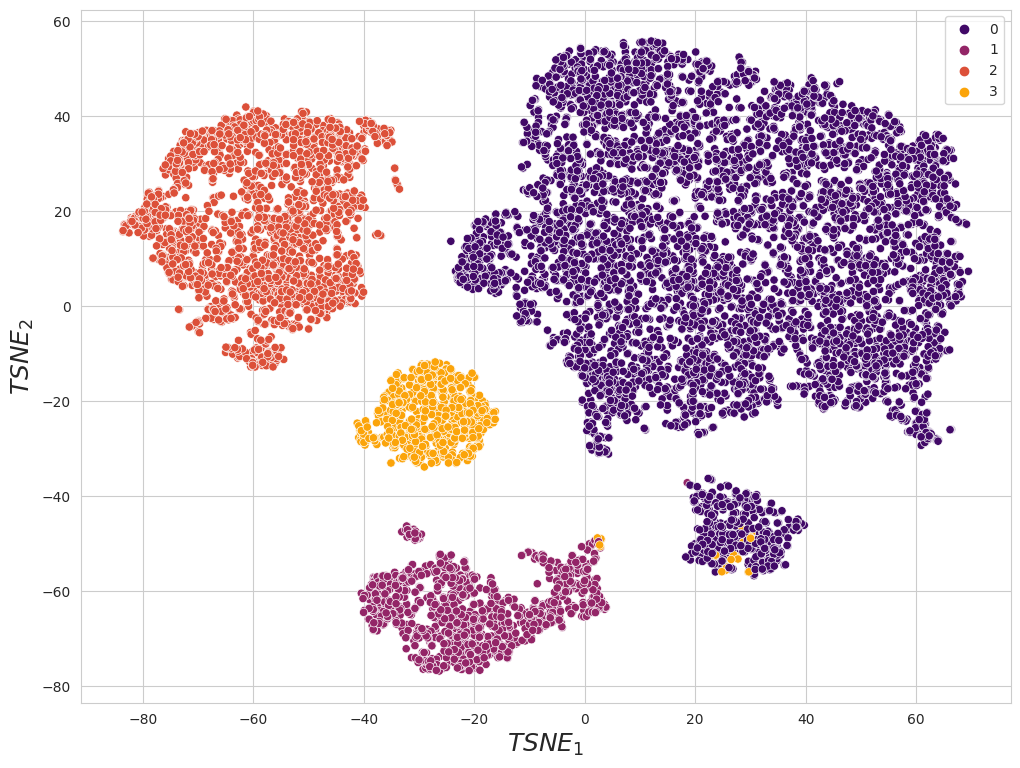

In [33]:
plot_tsne(fc_data, color=kmeans_res.labels_);

In [34]:
silhouette_score(fc_data, kmeans_res.labels_)

0.6103014000983125

In [35]:
# Agglomerative Clustering
# покрасить кластеры получилось очень хорошо, надо было только помучить порог расстояния
agg_clusterer = AgglomerativeClustering(n_clusters=None, 
                                        distance_threshold=100)
agg_res = agg_clusterer.fit(fc_data)
np.unique(agg_res.labels_)

array([0, 1, 2, 3])

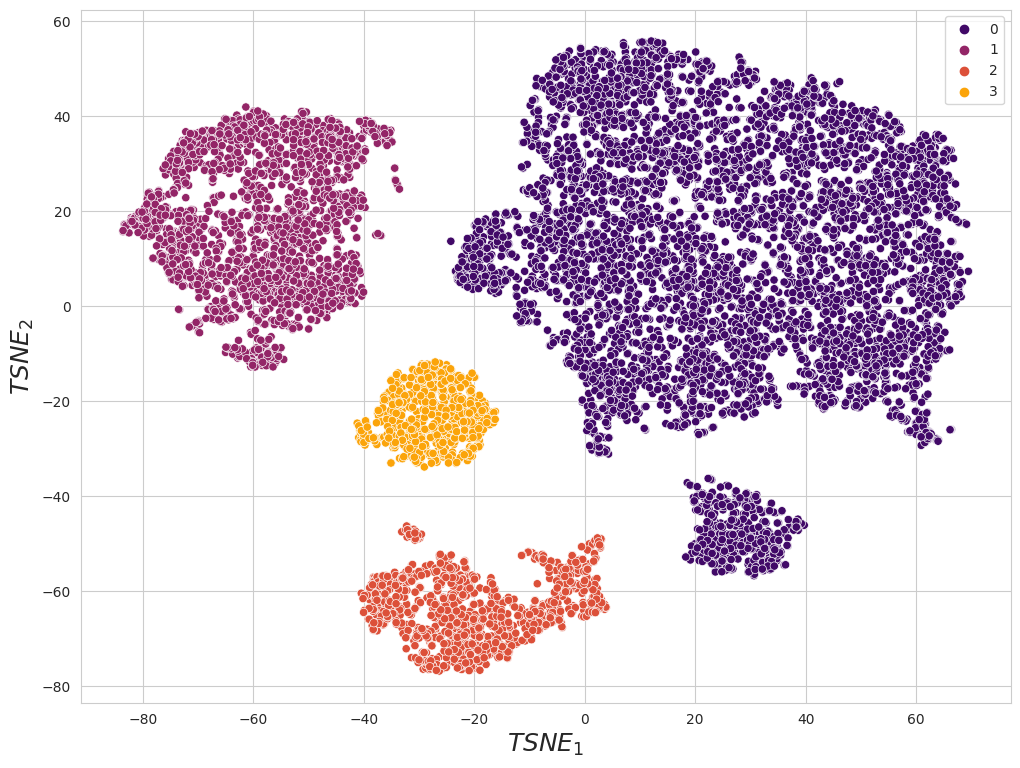

In [36]:
plot_tsne(fc_data, color=agg_res.labels_);

In [37]:
silhouette_score(fc_data, agg_res.labels_)

0.6114468221314616

In [38]:
# DBSCAN
# в данном случае долго мучилась, но не получается: 
# один кластер упорно назначается шумом, объединяется не то, что нужно, в общем, у него тут своя атмосфера
dbscan_clusterer = DBSCAN(eps=2, min_samples=30)
dbscan_res = dbscan_clusterer.fit(fc_data)
np.unique(dbscan_res.labels_)

array([-1,  0,  1,  2])

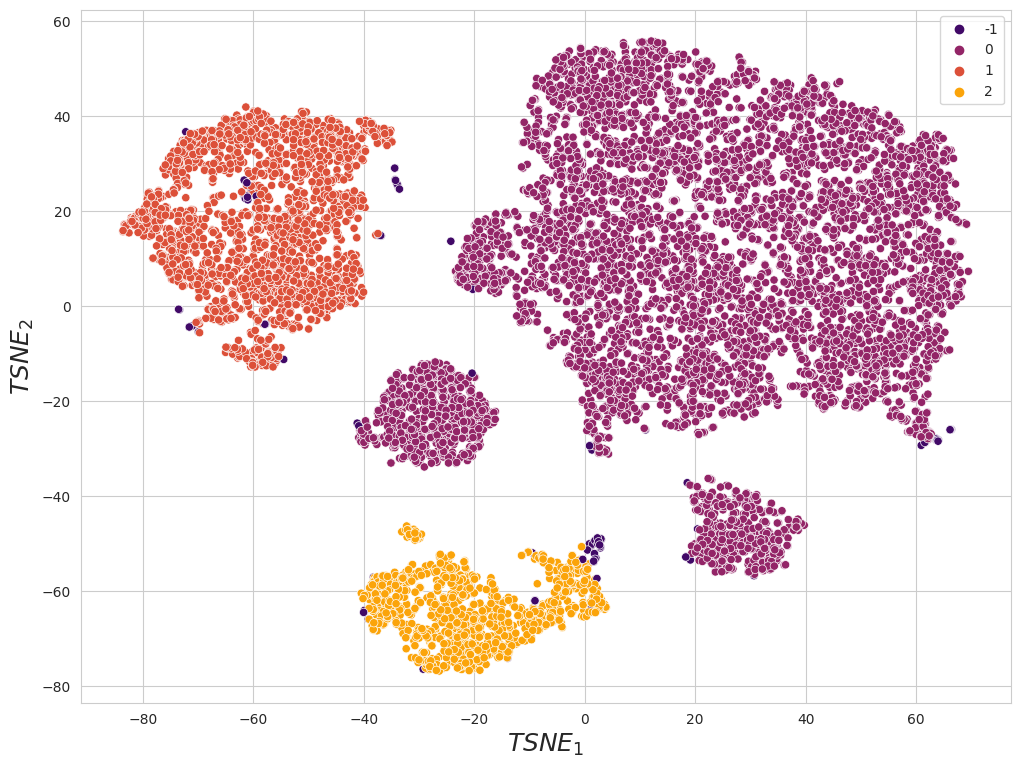

In [39]:
plot_tsne(fc_data, color=dbscan_res.labels_);

In [40]:
silhouette_score(fc_data, dbscan_res.labels_)

0.6066776960062027

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

В общем, да: ближе всех к этому результату подошёл Agglomerative Clustering (silhouette_score = 0.61), K-Means тоже похож на правду с учётом выбросов (silhouette_score = 0.61).

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

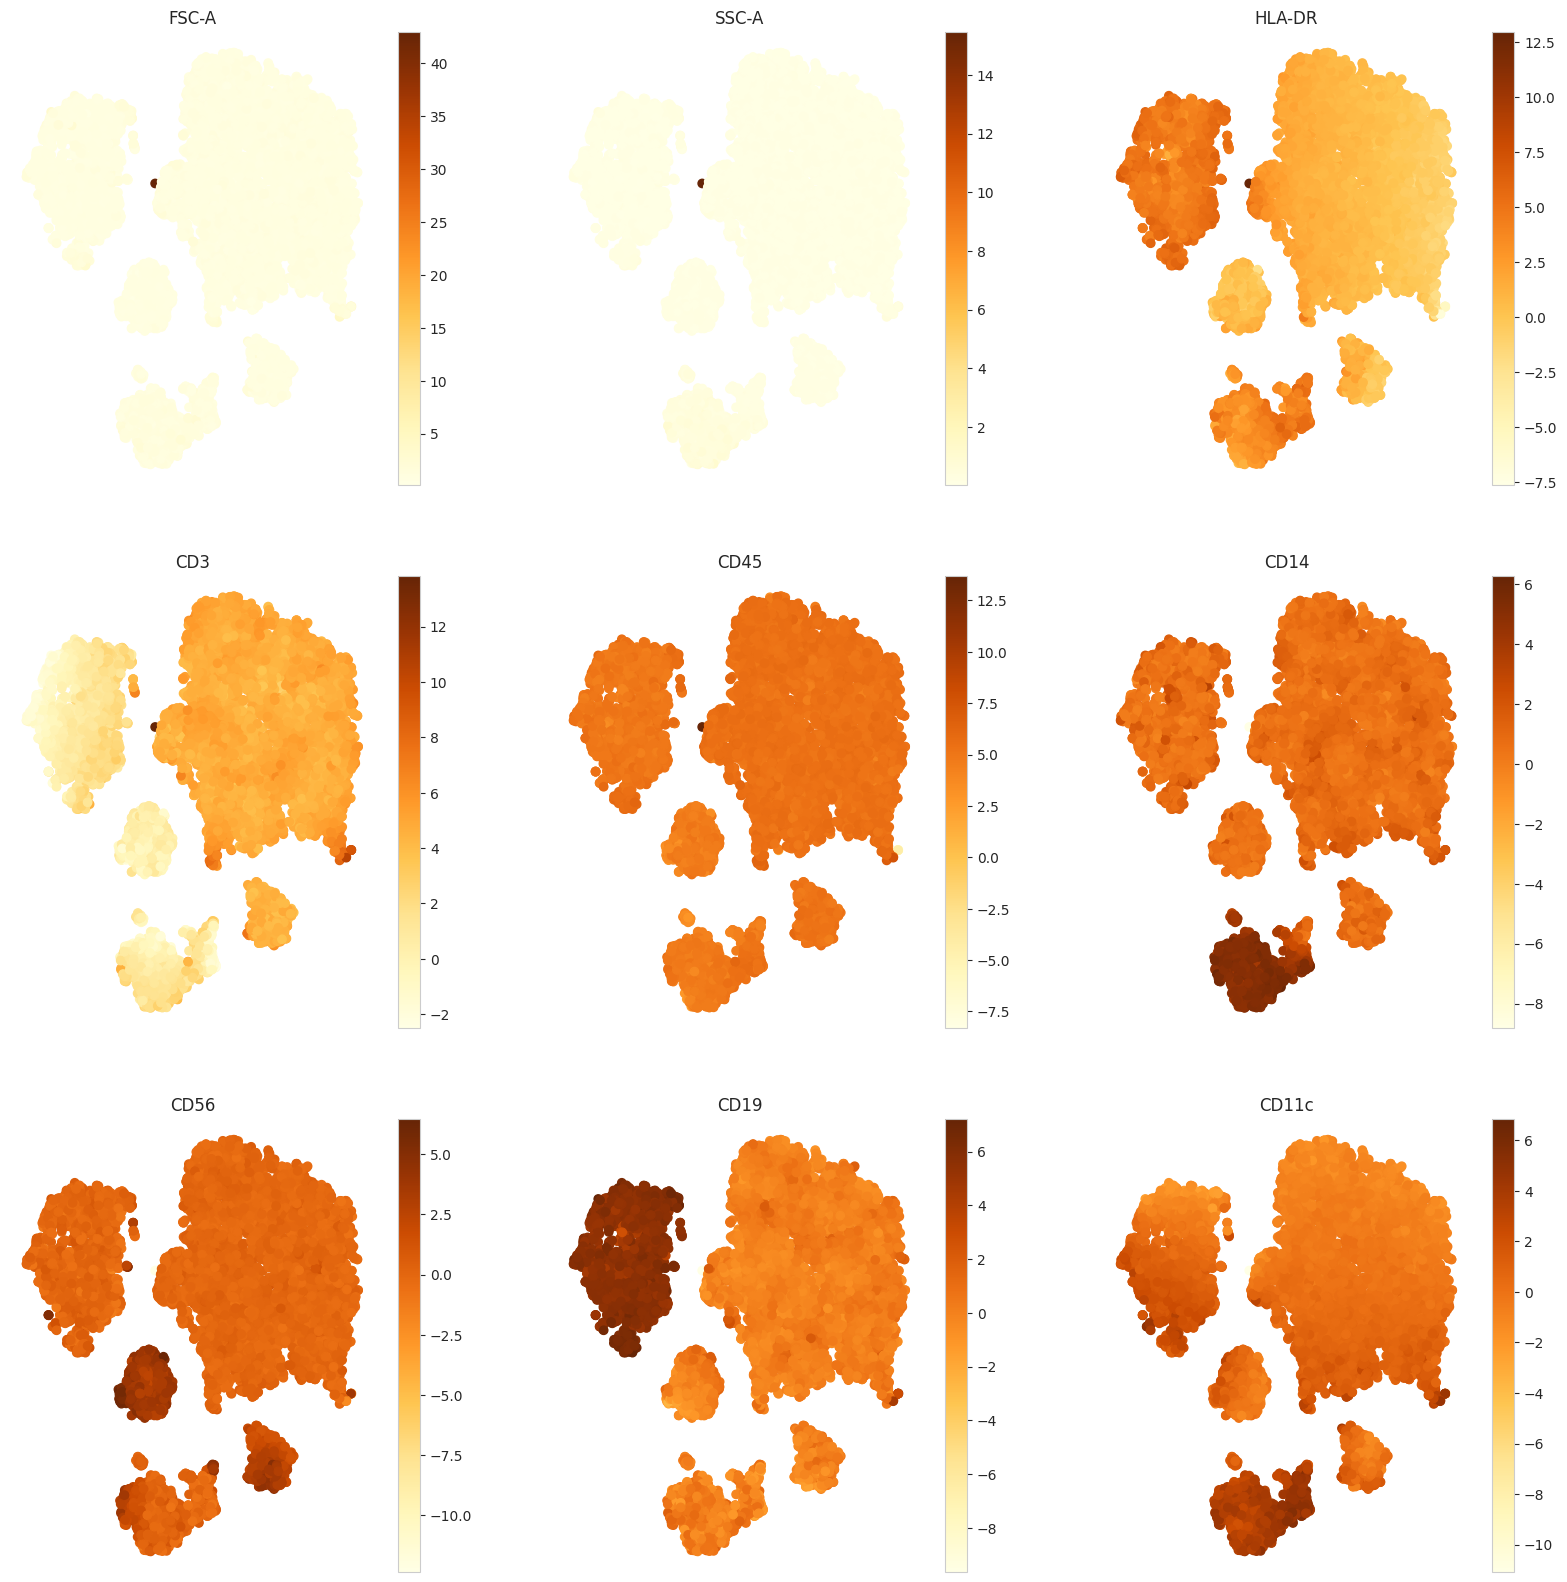

In [41]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [42]:
cell_type_cluster_map = {0: "Other cells", 
                         1: "B lymphocytes", 
                         2: "Monocytes", 
                         3: "T cells"}

In [43]:
labeled_fc_data = fc_data.assign(Population=agg_res.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)
labeled_fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c     Population  
0    -1.406912  0.384406        T cells  
1     6.034845  0.577039  B lymphocytes  
2    -0.318668 -0.493832    Other cells  
3     0.694883  3.416960    Other cells  
4     5.563345  0.471591  B lymphocytes  
...        ...       ...            ...  
9995 -0.591343  2.857737      Monocytes  
9996  0.344169 -0.626795    Other cells  
9997 -0.887078  4.369294      Monocytes  
9998 -0.112999  0.069239        T cells  
9999 -0.441455  0.378331        T cells  

[10000 rows x 10 columns]

Посчитайте, как распределены типы клеток:

In [44]:
population_count = pd.DataFrame(labeled_fc_data.groupby("Population").Population.count()).\
reset_index(names="reset_index").rename(columns={"reset_index": "Population", "Population": "Count"})
population_count

Population  Count
0  B lymphocytes   2035
1      Monocytes   1099
2    Other cells   6231
3        T cells    635

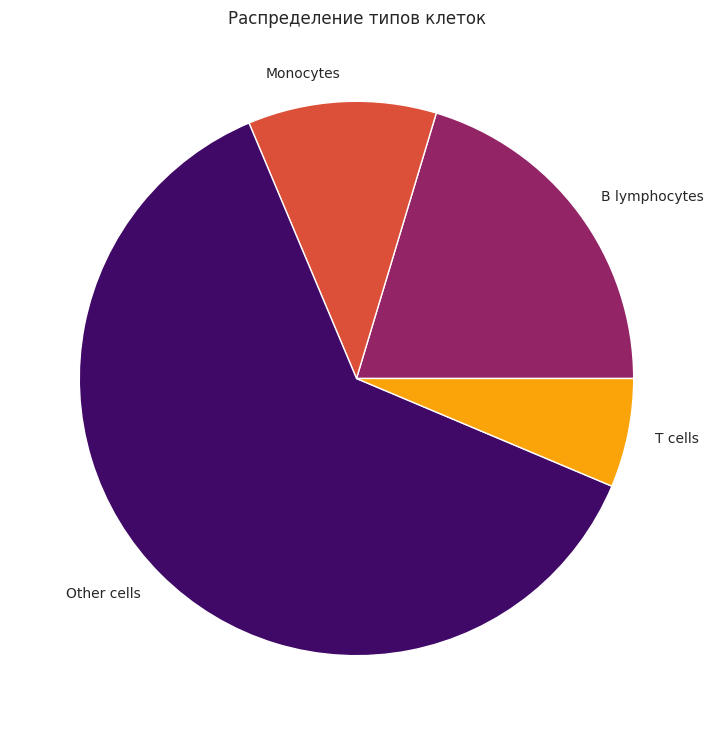

In [45]:
plt.pie(population_count.Count, 
        labels=population_count.Population,
        colors=["#932567", "#DC5039", "#410967", "#FBA40A"])
plt.title("Распределение типов клеток");

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [46]:
population_count.to_csv("data/population_count.csv")

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [47]:
# делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(labeled_fc_data.drop("Population", axis=1), 
                                                    labeled_fc_data.Population, 
                                                    test_size=0.1, 
                                                    random_state=SEED)

In [48]:
params = [1, 3, 5, 8, 10, 15]

In [49]:
# KNeighborsClassifier
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), labeled_fc_data.drop("Population", axis=1).columns)
])

preprocessor.transformers

[('scaler',
  StandardScaler(),
  Index(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
         'CD11c'],
        dtype='object'))]

In [50]:
for k in params:
    knn_pipeline = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("knn", KNeighborsClassifier(n_neighbors=k, weights="distance"))
                            ])
    knn_pipeline.fit(X_train, y_train)
    y_pred = knn_pipeline.predict(X_test)
    print(f"With k = {k} F1 = {f1_score(y_test, y_pred, average='macro')}")
    print()

With k = 1 F1 = 1.0

With k = 3 F1 = 1.0

With k = 5 F1 = 1.0

With k = 8 F1 = 1.0

With k = 10 F1 = 1.0

With k = 15 F1 = 1.0



In [51]:
# Logistic Regression
solvers = ["newton-cg", "sag", "saga", "lbfgs"]
for solver in solvers:
    log_reg_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("log_reg", LogisticRegression(class_weight="balanced", solver=solver))
    ])
    log_reg_pipeline.fit(X_train, y_train)
    y_pred = log_reg_pipeline.predict(X_test)
    print(f"With solver = {solver} F1 = {f1_score(y_test, y_pred, average='macro')}")
    print()

With solver = newton-cg F1 = 1.0

With solver = sag F1 = 1.0

With solver = saga F1 = 1.0

With solver = lbfgs F1 = 1.0



In [52]:
depths = [1, 2, 3, 4, 5, 8, 10, 15, 20, 30, 100, 1000]

In [53]:
# DecisionTreeClassifier (раз уж делаю ДЗ после лекции про деревья)
for depth in depths:
    tree_pipeline_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("tree", DecisionTreeClassifier(max_depth=depth, criterion="log_loss"))
    ])
    tree_pipeline_pipeline.fit(X_train, y_train)
    y_pred = tree_pipeline_pipeline.predict(X_test)
    print(f"With max depth = {depth} F1 = {f1_score(y_test, y_pred, average='macro')}")
    print()

# можно выбрать глубину 4 - после этого дерево уже начинает свою любимую затею с переобучением

With max depth = 1 F1 = 0.4218332618573115

With max depth = 2 F1 = 0.6886412516688794

With max depth = 3 F1 = 0.9832985565719097

With max depth = 4 F1 = 1.0

With max depth = 5 F1 = 1.0

With max depth = 8 F1 = 0.9982255360961794

With max depth = 10 F1 = 0.9982255360961794

With max depth = 15 F1 = 1.0

With max depth = 20 F1 = 1.0

With max depth = 30 F1 = 1.0

With max depth = 100 F1 = 1.0

With max depth = 1000 F1 = 0.9982255360961794



With max depth = 2 F1 = 0.6886412516688794


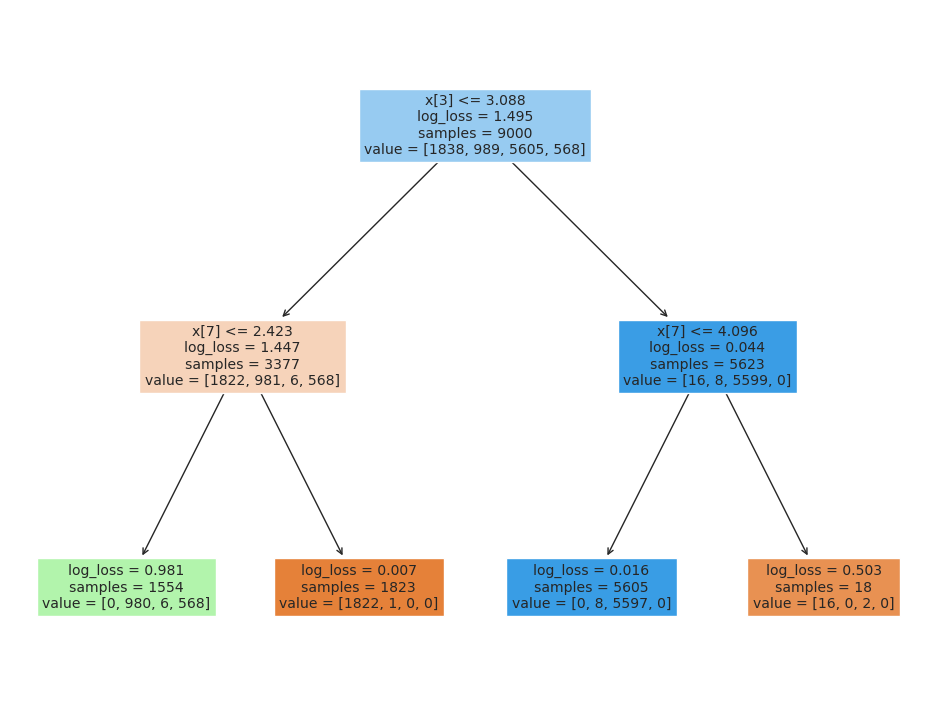

In [54]:
# Можно ради интереса нарисовать маленький график и заодно убедиться, что дереву не так важна предобработка данных, как для 
# ранее изученных методов: без масштабирования показатель F1 для данной глубины не изменился
show_tree = DecisionTreeClassifier(max_depth=2,  criterion="log_loss")
show_tree.fit(X_train, y_train)
y_pred = show_tree.predict(X_test)
print(f"With max depth = 2 F1 = {f1_score(y_test, y_pred, average='macro')}")
plot_tree(show_tree, filled=True);

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Этой весной - дожить до выпускного в Питере, присутствовать на выпускном в Питере.    
Фотка_c_набережной_Невы.palette=["magma"]   
:)
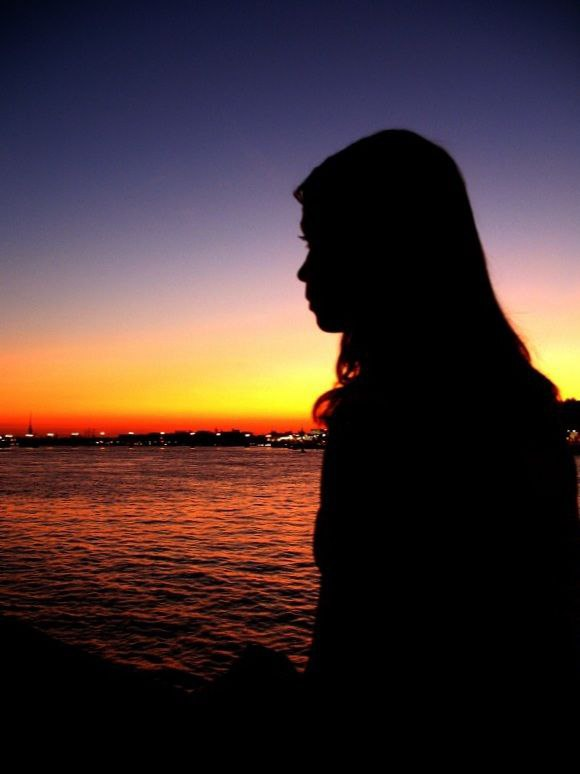

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Всё ок. :)